# 02 - Training Model

The notebook contains pipeline for training CNN model.

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
import numpy as np
import pandas as pd

import torch
from fastai.vision.all import (ToTensor, Normalize, Resize,
                               Learner, CSVLogger, SaveModelCallback, GradientAccumulation,
                               Adam, RAdam, SGD, ReduceLROnPlateau)

from src.core import models, loss_functions, metrics, data, augmentation as aug
from src.utils import nb_setup, io
from src.dev import experiments as exp


DATA_DIR = 'data/snake_clef2021_dataset/'
TRAIN_SET_DIR = 'train'

SEED = 42

nb_setup.init()
nb_setup.set_random_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## Select Training Configuration (network architecture, loss, optimizer, ...)

In [3]:
config = exp.create_config(
    model='resnest101',
    loss='ce',
    opt='sgd',
    no_epochs=30,
    batch_size=128,
    total_batch_size=128,
    learning_rate=0.01,  # sgd
    # learning_rate=0.001,  # adam
    # learning_rate=0.0001,  # 0.0005 adam vit
    wd=0.01,
    full_ds=False,
    aug=False,
    scheduler=False,
    mixed_precision=True,
    # note=''
)

config['input_size'] = models.MODEL_INPUT_SIZES[config.model]
_model_config = models.get_model_config(config.model)
config['model_mean'] = _model_config['mean']
config['model_std'] = _model_config['std']

loss_fn = loss_functions.LOSSES[config.loss]
OPTIMS = {
    'adam': Adam,
    'radam': RAdam,
    'sgd': lambda *a, **k: SGD(*a, mom=0.9, **k)}
opt_fn = OPTIMS[config.opt]

print(config)

256
Config(
* model_name: clef2021_resnest101_ce_06-24-2021_12-25
* history_file: clef2021_resnest101_ce_06-24-2021_12-25.csv
* specs_name: clef2021_resnest101_ce_06-24-2021_12-25.json
* model: resnest101
* loss: ce
* opt: sgd
* no_epochs: 30
* batch_size: 128
* total_batch_size: 128
* learning_rate: 0.01
* wd: 0.01
* full_ds: False
* aug: False
* scheduler: False
* mixed_precision: True
* input_size: 224
* model_mean: (0.485, 0.456, 0.406)
* model_std: (0.229, 0.224, 0.225))


## Load the Data

In [4]:
# load metadata
if config.full_ds:
    train_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_train_metadata_PROD.csv')

    # remove flickr images as they are not validated
    train_df = train_df[train_df['source'] != 'flickr']
    train_df = data.get_valid_col(train_df, ['binomial', 'country'], 'valid', valid_pct=0.1)
else:
    train_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_min-train_metadata_PROD.csv')
    train_df = data.get_valid_col(train_df, ['binomial', 'country'], 'valid', valid_pct=0.2)

no_classes = len(train_df['binomial'].drop_duplicates())
print('No classes:', no_classes)

No classes: 768


In [5]:
species = np.unique(train_df['binomial'])
countries = np.unique(train_df['country'])

# load country-species map, country-country LuT and rename countries
country_map_df = pd.read_csv(DATA_DIR + 'species_to_country_mapping.csv', index_col=0)

# create country weight matrix
country_weights = metrics.clean_country_map(country_map_df, species, missing_val=0)
country_weights = torch.Tensor(country_weights.values).to(device)

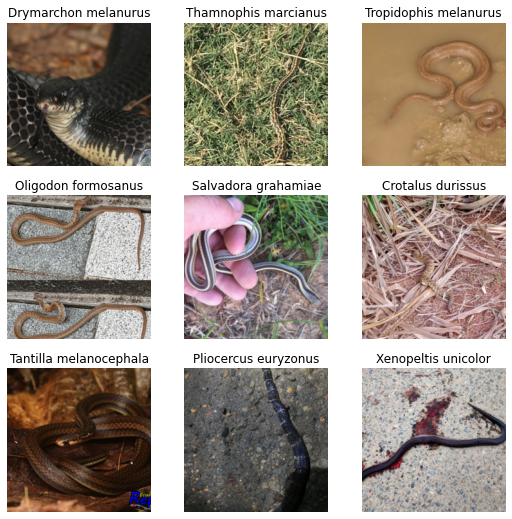

In [6]:
# define transforms
item_tfms = [ToTensor, Resize(config.input_size)]
if config.aug:
    batch_tfms = [*aug.get_simple_tfms(),
                  Normalize.from_stats(config.model_mean, config.model_std)]
else:
    batch_tfms = Normalize.from_stats(config.model_mean, config.model_std)

# create image data loaders
dls, dblock = data.create_dls(
    train_df, path=DATA_DIR, folder=TRAIN_SET_DIR,
    fn_col='image_path', label_col='binomial', valid_col='valid',
    bs=config.batch_size, item_tfms=item_tfms, batch_tfms=batch_tfms,
    num_workers=4, device=device)

dls.show_batch()

## Train the Model Using fastai Learner

In [7]:
# create csv logger and save model callbacks
csv_logger_cb = CSVLogger(fname=config.history_file, append=True)
save_model_cb = SaveModelCallback(
    monitor='country_f1_score', fname=config.model_name)
grad_accum_cb = GradientAccumulation(n_acc=config.total_batch_size)

# create model learner
learner = Learner(
    dls,
    model=models.get_model(config.model, no_classes, pretrained=True),
    loss_func=loss_fn(country_weights=country_weights),
    opt_func=opt_fn,
    metrics=[metrics.pytorch.accuracy,
             metrics.pytorch.F1Score(),
             metrics.pytorch.CountryF1Score(country_weights)],
    cbs=[csv_logger_cb, save_model_cb, grad_accum_cb])
learner.unfreeze()

if config.mixed_precision:
    learner = learner.to_fp16()

# if not config.scheduler:
#     reduce_lr_cb = ReduceLROnPlateau(
#         monitor='country_f1_score', comp=np.greater, min_delta=0.01, min_lr=1e-8,
#         patience=2, factor=10)
#     learner.add_cb(reduce_lr_cb)

In [ ]:
# save config file
config.save(DATA_DIR + config.specs_name)

# train model
if config.scheduler:
    learner.fit_one_cycle(config.no_epochs, lr_max=config.learning_rate,
                          wd=config.wd)
else:
    learner.fit(config.no_epochs, lr=config.learning_rate, wd=config.wd)

# plot loss history
learner.recorder.plot_loss()

In [ ]:
# # find learning rate
# learner.lr_find()

In [ ]:
# # show results
# learner.show_results()